In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import metrics, datasets, neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from imbalanced_ensemble.datasets import generate_imbalance_data
from imbalanced_ensemble.utils._plot import plot_2Dprojection_and_cardinality
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Classification model evaluation

In [2]:
# Let's generate ideal dataset for binary classification
X,y  = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=0)
X.shape, y.shape

((1000, 10), (1000,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
X_train.shape, X_test.shape, 

((800, 10), (200, 10))

In [4]:
clf = LogisticRegression().fit(X_train, y_train)

In [5]:
preds = clf.predict(X_test)

print(preds[:5])
print(y_test[:5])

print('Test Accuracy : %.3f'%(preds == y_test).mean())
print('Test Accuracy : %.3f'%clf.score(X_test, y_test))
print('Training Accuracy : %.3f'%clf.score(X_train, y_train))

[0 1 0 0 1]
[0 1 0 1 1]
Test Accuracy : 0.940
Test Accuracy : 0.940
Training Accuracy : 0.953


Let's look at confusion matrix, for binary problem cm is ordered as follows:<br>
[[TN FP]<br>
[FN TP]]

[[96  4]
 [ 8 92]]


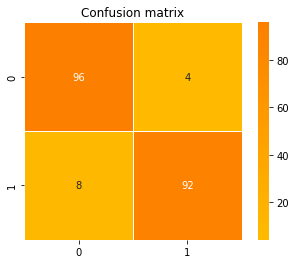

In [6]:
cm = confusion_matrix(y_test, preds)
print(cm)
sns.heatmap(cm, annot=True, linecolor='white', linewidths=1.0, square=True, cmap='Wistia', center=0.0)
plt.title('Confusion matrix')
plt.show()

In [7]:
print('Precision: %.3f'%precision_score(y_test, preds))
print('Recall: %.3f'%recall_score(y_test, preds))
print('F1-Score: %.3f'%f1_score(y_test, preds))
print(classification_report(y_test, preds))

Precision: 0.958
Recall: 0.920
F1-Score: 0.939
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       100
           1       0.96      0.92      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



### Imbalanced multiclass dataset

Train class distribution:  Counter({0: 558, 1: 139, 2: 42, 3: 41, 4: 20})
Test class distribution:   Counter({0: 139, 1: 35, 2: 11, 3: 10, 4: 5})


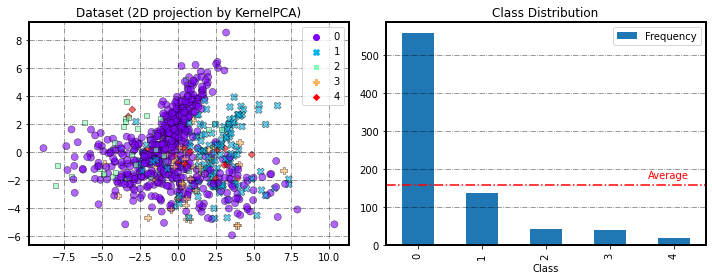

In [8]:
X_train, X_test, y_train, y_test = generate_imbalance_data(n_samples=1000, weights=[.7,.2,.1,.1,.05], 
                                                           test_size=.2,
                                                           kwargs={'n_informative': 5, 'n_features':10,},)

print ("Train class distribution: ", Counter(y_train))
print ("Test class distribution:  ", Counter(y_test))
plot_2Dprojection_and_cardinality(X_train, y_train)
plt.show()

In [9]:
# We will use crossvalidation for this example, the problem with too few samples in some classes will become more prominent
cv_res = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

# the resulting accuracy does not look so bad, let's look closer
cv_res

array([0.85625, 0.8875 , 0.88125, 0.8875 , 0.85625])

Accuracy does not represent the model performance well in the case of imbalanced dataset.<br>
The solution is to use precision, recall, f1-score, mcc, ROC/AUC and of course also report confusion matrix

In [10]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

# Here you can see that low represented classes metrics are bad - never use accuracy
# as model evaluation metrics for an imbalanced and multiclass problem
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       139
           1       0.87      0.77      0.82        35
           2       0.70      0.64      0.67        11
           3       0.67      0.60      0.63        10
           4       0.80      0.80      0.80         5

    accuracy                           0.87       200
   macro avg       0.79      0.75      0.77       200
weighted avg       0.87      0.87      0.87       200



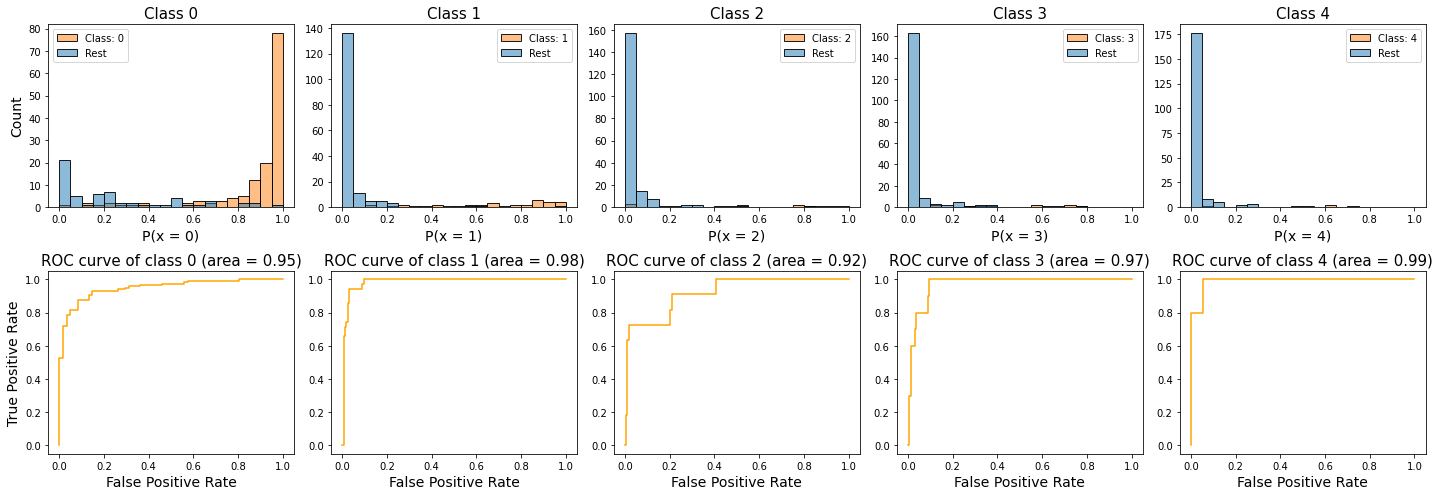

In [11]:
roc_auc_ovr = {}
ax_list = []
bins = [i/20 for i in range(20)] + [1]
plt.figure(figsize = (20, 7))
for i in clf.classes_:
    # Let's get probs for each class and calculate OvR
    df_temp = pd.DataFrame(X_test)
    df_temp['class'] = [1 if y == i else 0 for y in y_test]
    df_temp['prob'] = clf.predict_proba(X_test)[:, i]
    
    ax = plt.subplot(2, 5, i+1, )
    sns.histplot(x="prob", data=df_temp, hue='class', color='b', ax=ax, bins=bins)
    ax.set_title(f'Class {i}', fontsize=15)
    ax.legend([f"Class: {i}", "Rest"])
    ax.set_xlabel(f"P(x = {i})", fontsize=14)
    if i == 0:
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.set_ylabel('')

    ax_bottom = plt.subplot(2, 5, i+6)
    fpr, tpr, _ = roc_curve(df_temp['class'], df_temp['prob'])
    roc_auc_ovr = roc_auc_score(df_temp['class'], df_temp['prob'])
    plt.plot(fpr, tpr, color='orange')
    plt.xlabel("False Positive Rate", fontsize=14)
    if i == 0:
        plt.ylabel("True Positive Rate", fontsize=14)    
    
    ax_bottom.set_title('ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_ovr), fontsize=15)
    


plt.tight_layout()

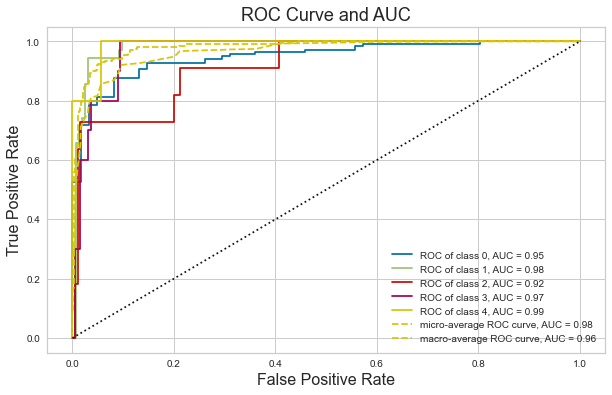

In [12]:
# Alternatively yellowbrick library can be used
from yellowbrick.classifier import ROCAUC


plt.figure(figsize=(10,6))
plt.title("ROC Curve and AUC", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
visualizer = ROCAUC(LogisticRegression(),)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.legend()
plt.show()

In case of imbalanced dataset good practice is to report also a Precision Recall curve.
ROC / AUC looks just fine, but that is not the case with PR curve. Remember, you need to explore the data before
the modelling step and after the training phase is done exploring many metrics is important; so you can properly evaluate the results.

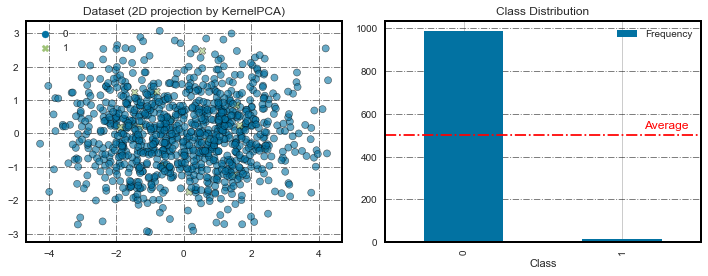

In [13]:
# generate the data
X, y = datasets.make_classification(n_samples=1000, 
                           n_classes=2, 
                           weights=[0.99, 0.01], 
                           random_state=0)

plot_2Dprojection_and_cardinality(X, y)
plt.show()

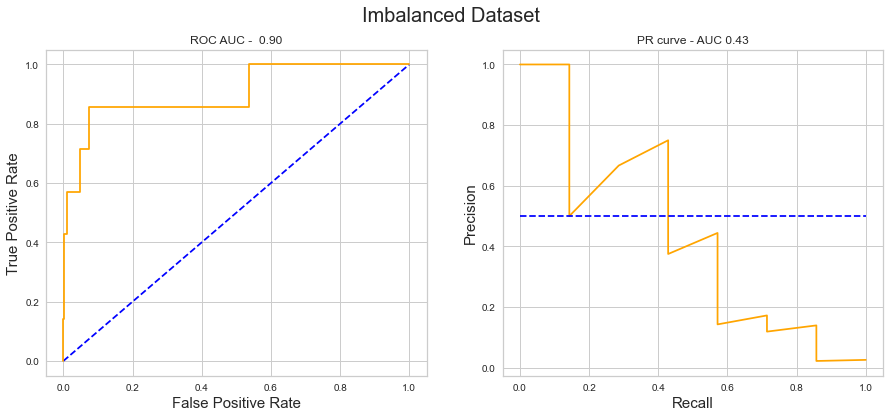

In [16]:
clf = LogisticRegression()
fpr, tpr, recall, precision, pos_probs = compute_classif_metrics(X, y, clf)

plot_the_data(fpr, tpr, recall, precision, 'Imbalanced Dataset')

#### Helper functions

In [15]:
def compute_classif_metrics(X, y, model):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, 
                                                        stratify=y, random_state=0)    
    model.fit(train_X, train_y)

    pred_y = model.predict_proba(test_X)
    pos_probs = pred_y[:, 1]

    precision, recall, _ = precision_recall_curve(test_y, pos_probs)
    fpr, tpr, _ = roc_curve(test_y, pos_probs)
    
    return fpr, tpr, recall, precision, pos_probs

def plot_the_data(fpr, tpr, recall, precision, suptitle):
    fig = plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    roc_auc = auc(fpr, tpr)
    ident = [0.0, 1.0]
    plt.plot(ident,ident, linestyle='dashed', color='blue')
    plt.plot(fpr, tpr, label='classifier', color='orange')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC AUC -  %.2f' % roc_auc)

    plt.subplot(1,2,2)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label='classifier', color='orange')
    plt.hlines(0.5,0.0,1.0, linestyle='dashed', colors=['blue'])
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.title('PR curve - AUC %.2f' % auc_score)
    plt.suptitle(suptitle, fontsize=20)